In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

# Connect to PostgreSQL
db_uri = {db_uri}
engine = create_engine(db_uri)

# Query to get influencer mentions
query = """
SELECT p.influencer_id AS source, i2.influencer_id AS target
FROM post_details pd
JOIN posts p ON pd.post_id = p.post_id
JOIN influencers i1 ON p.influencer_id = i1.influencer_id
JOIN influencers i2 ON i2.username = ANY(string_to_array(pd.usertags, ', '))
WHERE i2.influencer_id IS NOT NULL;
"""
df = pd.read_sql(query, engine)

# Fetch Influencer Usernames
usernames_query = "SELECT influencer_id, username FROM influencers;"
influencer_map = pd.read_sql(usernames_query, engine).set_index("influencer_id")["username"].to_dict()

engine.dispose()

# Build Graph
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row["source"], row["target"])

# Compute PageRank
pagerank_scores = nx.pagerank(G)

# Convert to DataFrame
pagerank_df = pd.DataFrame({
    "Influencer_ID": list(pagerank_scores.keys()),
    "Username": [influencer_map.get(node, "Unknown") for node in pagerank_scores.keys()],
    "PageRank": list(pagerank_scores.values())
}).sort_values(by="PageRank", ascending=False)

# Show top influencers
print(pagerank_df.head(10))

      Influencer_ID             Username  PageRank
14              283  urbandecaycosmetics  0.026779
4419            520       whitneymadueke  0.016085
553             500          iluvsarahii  0.014463
27            14656          thefeedfeed  0.007913
47            10337          desiperkins  0.005808
48             7788                 katy  0.005635
25              658       kristenxleanne  0.005124
4420            738       naturallycurly  0.004708
85            14851           spicentice  0.004656
275             893        patrickstarrr  0.004460


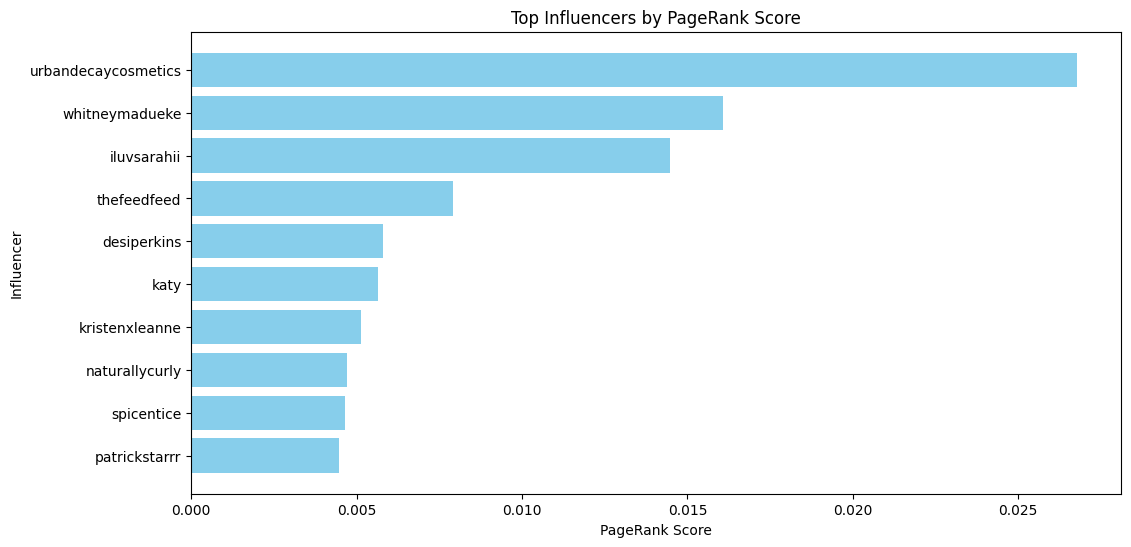

In [4]:
# Select top 10 influencers
top_n = 10
top_influencers = pagerank_df.head(top_n)

# Bar Chart
plt.figure(figsize=(12, 6))
plt.barh(top_influencers["Username"], top_influencers["PageRank"], color="skyblue")
plt.xlabel("PageRank Score")
plt.ylabel("Influencer")
plt.title("Top Influencers by PageRank Score")
plt.gca().invert_yaxis()  # Invert so highest ranked is on top
plt.show()

🔹 Top 10 Most Influential Influencers (by PageRank):
                 Username  PageRank
14    urbandecaycosmetics  0.026779
4419       whitneymadueke  0.016085
553           iluvsarahii  0.014463
27            thefeedfeed  0.007913
47            desiperkins  0.005808
48                   katy  0.005635
25         kristenxleanne  0.005124
4420       naturallycurly  0.004708
85             spicentice  0.004656
275         patrickstarrr  0.004460 

🔹 Average PageRank Score: 0.000149

🔹 Influence Gap (Top Influencer vs Second Most Influential): 0.010695

🔹 Bottom 10 Least Influential Influencers:
             Username  PageRank
4666   pulsamospelows  0.000056
4674       royailmaz0  0.000056
4677  tuyennguyen2906  0.000056
1864      xoxorajshel  0.000056
1866  ritalanevintage  0.000056
1868     facesbyaimee  0.000056
1869      tamiastyles  0.000056
2115      mlbjoeflano  0.000056
1875   lovefreshpaint  0.000056
3057        vvarholla  0.000056


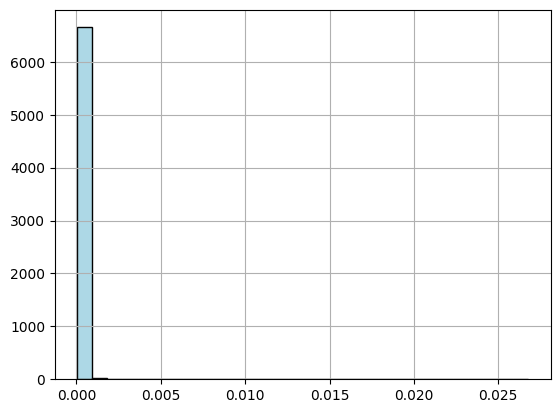

In [5]:
# Step 1: Extract Key Insights from PageRank

# 🔹 Top 10 Most Influential Influencers
top_influencers = pagerank_df.head(10)

# 🔹 Average PageRank Score
average_pagerank = pagerank_df["PageRank"].mean()

# 🔹 Distribution of Influence
pagerank_df["PageRank"].hist(bins=30, color="lightblue", edgecolor="black")

# 🔹 Influence Gap (Difference Between Top and Rest)
top_score = top_influencers.iloc[0]["PageRank"]
second_score = top_influencers.iloc[1]["PageRank"]
influence_gap = top_score - second_score

# 🔹 Bottom 10 Influencers (Least Influence)
least_influencers = pagerank_df.tail(10)

# Step 2: Print Insights
print("🔹 Top 10 Most Influential Influencers (by PageRank):")
print(top_influencers[["Username", "PageRank"]], "\n")

print(f"🔹 Average PageRank Score: {average_pagerank:.6f}\n")

print(f"🔹 Influence Gap (Top Influencer vs Second Most Influential): {influence_gap:.6f}\n")

print("🔹 Bottom 10 Least Influential Influencers:")
print(least_influencers[["Username", "PageRank"]])

In [6]:
pagerank_df.to_sql('influencer_rankings', engine, if_exists='replace', index=False)

700